In [1]:
# Basic setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, r2_score

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Load your cleaned dataset
df = pd.read_csv("database/encoded_dataset.csv")
df.head()

,studyhours,attendance,resources,extracurricular,motivation,internet,gender,age,learningstyle,onlinecourses,discussions,assignmentcompletion,edutech,stresslevel,finalgrade
0,19,64,0,0,0,1,1,19,0,8,1,59,0,1,3
1,19,64,0,0,0,1,1,23,1,16,0,90,0,1,2
2,19,64,0,0,0,1,1,28,2,19,0,67,1,1,0
3,19,64,0,1,0,1,1,19,0,8,1,59,0,1,3
4,19,64,0,1,0,1,1,23,1,16,0,90,0,1,2


Dataset shape: (11790, 15)
['studyhours', 'attendance', 'resources', 'extracurricular', 'motivation', 'internet', 'gender', 'age', 'learningstyle', 'onlinecourses', 'discussions', 'assignmentcompletion', 'edutech', 'stresslevel', 'finalgrade']
Number of predictors: 14

Top features by p-value (smallest p = more evidence of difference across classes):
             feature   F_stat  p_value
         discussions 8.945959 0.000006
         stresslevel 5.484934 0.000921
assignmentcompletion 4.025487 0.007149
             edutech 2.336753 0.071642
       learningstyle 2.238500 0.081614
          attendance 2.102330 0.097669
              gender 1.642173 0.177335
       onlinecourses 1.639196 0.178010
          motivation 1.501477 0.211970
     extracurricular 1.482797 0.217014
            internet 1.399860 0.240775
           resources 1.216649 0.301892
                 age 0.993002 0.394922
          studyhours 0.192330 0.901676

Number of low-confidence predictions (max_prob < 0.5): 663 / 

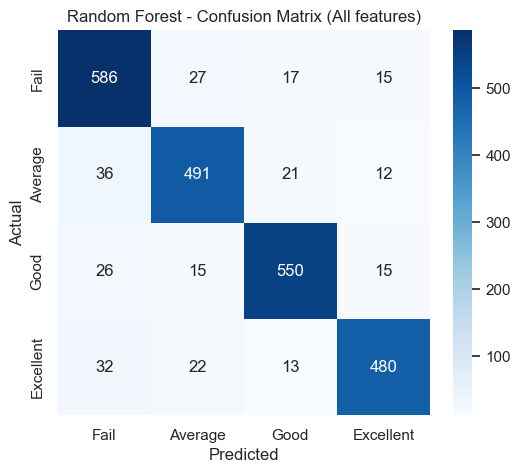

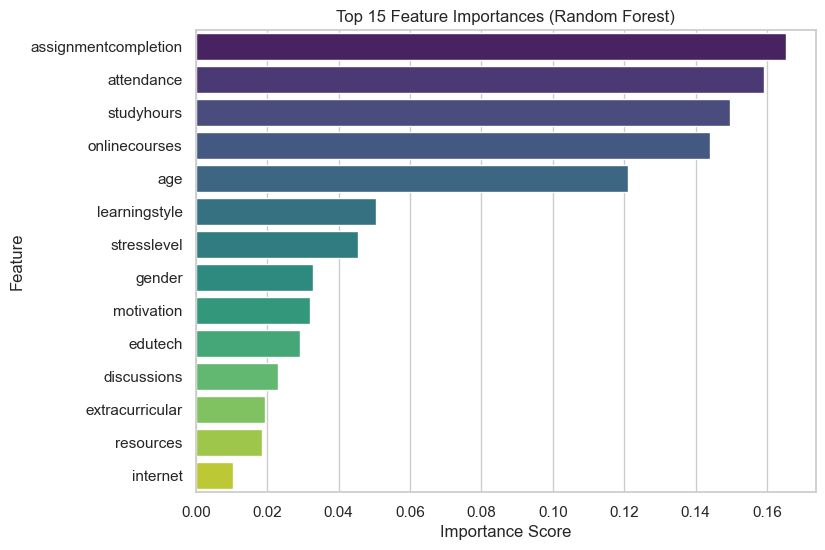


Top features by permutation importance:
             feature  perm_mean  perm_std
          attendance   0.193511  0.008481
assignmentcompletion   0.169063  0.006510
       onlinecourses   0.164207  0.006257
                 age   0.126802  0.005485
          studyhours   0.119953  0.005392
         stresslevel   0.105259  0.004983
         discussions   0.085899  0.004078
       learningstyle   0.066179  0.004369
              gender   0.046628  0.004402
             edutech   0.037638  0.002353
     extracurricular   0.002311  0.002344
           resources   0.001569  0.001414
            internet   0.001315  0.001047
          motivation  -0.001993  0.001638

Summary (importance + p-value):
                      rf_importance  perm_mean   p_value
feature                                                 
assignmentcompletion       0.165400   0.169063  0.007149
attendance                 0.159203   0.193511  0.097669
studyhours                 0.149545   0.119953  0.901676
onlinecours

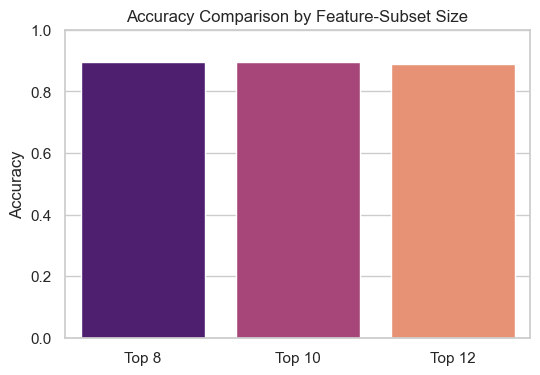

In [2]:
# Random Forest analysis using encoded_dataset.csv
# - p-values (ANOVA f_classif)
# - baseline RF with all features
# - threshold logic (max prob < 0.5 flagged)
# - top-8 / top-10 / top-12 comparisons
# - visuals

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import f_classif
from sklearn.inspection import permutation_importance


sns.set(style="whitegrid")

# --------------------------
# 1. Load dataset (encoded)
# --------------------------
df = pd.read_csv("database/encoded_dataset.csv")
print("Dataset shape:", df.shape)
print(df.columns.tolist())

# List of predictor columns (exclude finalgrade)
predictors = [c for c in df.columns if c != "finalgrade"]
print("Number of predictors:", len(predictors))

# X and y
X = df[predictors]
y = df["finalgrade"]

# --------------------------
# 2. Train/test split + scaling
# --------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --------------------------
# 3. Compute p-values (ANOVA f_classif)
# --------------------------
F, pvals = f_classif(X_train_scaled, y_train)
pvalues_df = pd.DataFrame({
    "feature": predictors,
    "F_stat": F,
    "p_value": pvals
}).sort_values("p_value")
print("\nTop features by p-value (smallest p = more evidence of difference across classes):")
print(pvalues_df.head(15).to_string(index=False))

# --------------------------
# 4. Train baseline Random Forest on ALL predictors
# --------------------------
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train_scaled, y_train)

# Standard prediction (argmax of predicted probabilities)
probs = rf.predict_proba(X_test_scaled)
y_pred_argmax = probs.argmax(axis=1)

# Apply threshold logic: flag low confidence where max probability < 0.5
max_probs = probs.max(axis=1)
low_confidence_idx = np.where(max_probs < 0.5)[0]
print(f"\nNumber of low-confidence predictions (max_prob < 0.5): {len(low_confidence_idx)} / {len(y_test)}")

# Evaluation
print("\n=== Baseline Random Forest (ALL features) ===")
print("Accuracy:", round(accuracy_score(y_test, y_pred_argmax), 3))
print("\nClassification Report:\n", classification_report(y_test, y_pred_argmax, zero_division=1))

# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred_argmax)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Fail","Average","Good","Excellent"],
            yticklabels=["Fail","Average","Good","Excellent"])
plt.title("Random Forest - Confusion Matrix (All features)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --------------------------
# 5. Feature importance (from RF) and permutation importance
# --------------------------
feat_imp = pd.Series(rf.feature_importances_, index=predictors).sort_values(ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(
    x=feat_imp.head(15).values,
    y=feat_imp.head(15).index,
    hue=feat_imp.head(15).index,   
    palette="viridis",
    legend=False               
)
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

# Permutation importance
perm = permutation_importance(rf, X_test_scaled, y_test, n_repeats=20, random_state=42, n_jobs=-1)
perm_df = pd.DataFrame({
    "feature": predictors,
    "perm_mean": perm.importances_mean,
    "perm_std": perm.importances_std
}).sort_values("perm_mean", ascending=False)
print("\nTop features by permutation importance:")
print(perm_df.head(15).to_string(index=False))

# Combine importance + p-values
summary = pd.DataFrame({
    "feature": predictors,
    "rf_importance": feat_imp.reindex(predictors).values,
    "perm_mean": perm_df.set_index("feature")["perm_mean"].reindex(predictors).values,
    "p_value": pvalues_df.set_index("feature")["p_value"].reindex(predictors).values
}).set_index("feature").sort_values("rf_importance", ascending=False)
print("\nSummary (importance + p-value):")
print(summary.head(15).to_string())

# --------------------------
# 6. Compare models using Top 8, Top 10, Top 12 features
# --------------------------
def evaluate_top_n(n):
    top_feats = feat_imp.head(n).index.tolist()
    Xtr = X_train[top_feats]
    Xte = X_test[top_feats]
    scaler_local = StandardScaler()
    Xtr_s = scaler_local.fit_transform(Xtr)
    Xte_s = scaler_local.transform(Xte)
    rf_local = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
    rf_local.fit(Xtr_s, y_train)
    y_pred = rf_local.predict(Xte_s)
    acc = accuracy_score(y_test, y_pred)
    print(f"\nTop {n} features: {top_feats}")
    print(f"Accuracy (Top {n}): {acc:.4f}")
    print(classification_report(y_test, y_pred, zero_division=1))
    return acc

acc8  = evaluate_top_n(8)
acc10 = evaluate_top_n(10)
acc12 = evaluate_top_n(12)

# Plot accuracy comparison
plt.figure(figsize=(6,4))
sns.barplot(
    x=["Top 8", "Top 10", "Top 12"],
    y=[acc8, acc10, acc12],
    hue=["Top 8", "Top 10", "Top 12"],
    palette="magma",
    legend=False
)

plt.ylim(0,1)
plt.title("Accuracy Comparison by Feature-Subset Size")
plt.ylabel("Accuracy")
plt.show()



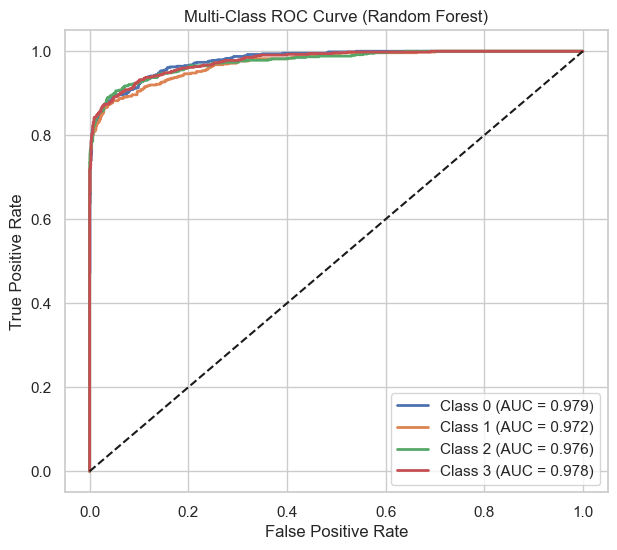

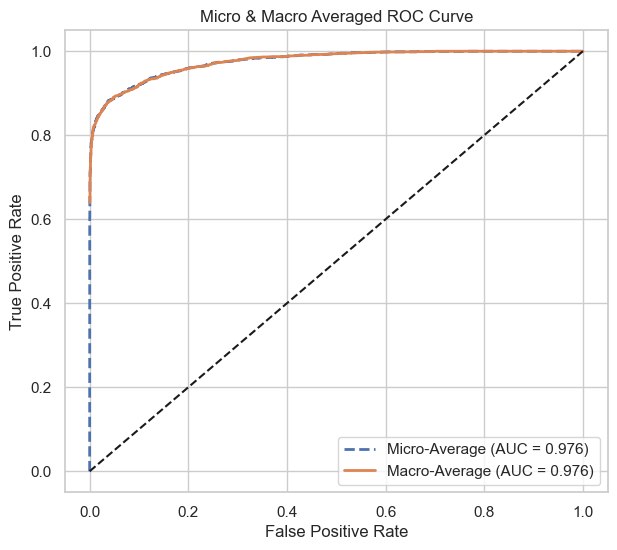


=== AUC Score Summary ===
Class 0 AUC: 0.979
Class 1 AUC: 0.972
Class 2 AUC: 0.976
Class 3 AUC: 0.978

Micro-Averaged AUC: 0.976
Macro-Averaged AUC: 0.976



In [4]:
# Multi-Class ROC Curve + Micro/Macro AUC (Random Forest)
# --------------------------
# 7. ROC Curve
# --------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score


# Load Data
df = pd.read_csv("database/encoded_dataset.csv")

X = df.drop("finalgrade", axis=1)
y = df["finalgrade"]

classes = sorted(y.unique())

# Train-Test Split & Scaling
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Train One-vs-Rest Random Forest
rf_ovr = OneVsRestClassifier(
    RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
)
rf_ovr.fit(X_train_scaled, y_train)

# Predicted probabilities for ROC
y_score = rf_ovr.predict_proba(X_test_scaled)

# Binarize labels (required for multi-class ROC)
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

# ------------------------------------
# 1. Plot ROC for Each Class
# ------------------------------------

plt.figure(figsize=(7,6))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Class {classes[i]} (AUC = {roc_auc:.3f})")

# Diagonal reference line
plt.plot([0,1], [0,1], "k--")

plt.title("Multi-Class ROC Curve (Random Forest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# ------------------------------------
# 2. Micro & Macro Averaged ROC
# ------------------------------------
# Micro-average
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
auc_micro = auc(fpr_micro, tpr_micro)

# Macro-average
auc_macro = roc_auc_score(y_test_bin, y_score, average="macro")

plt.figure(figsize=(7,6))
plt.plot(fpr_micro, tpr_micro, linestyle="--", linewidth=2,
         label=f"Micro-Average (AUC = {auc_micro:.3f})")

# Create macro curve
mean_tpr = np.zeros_like(fpr_micro)
for i in range(n_classes):
    fpr_i, tpr_i, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    mean_tpr += np.interp(fpr_micro, fpr_i, tpr_i)
mean_tpr /= n_classes

plt.plot(fpr_micro, mean_tpr, linewidth=2,
         label=f"Macro-Average (AUC = {auc_macro:.3f})")

plt.plot([0,1], [0,1], "k--")
plt.title("Micro & Macro Averaged ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# ------------------------------------
# 3. AUC Score Summary Table
# ------------------------------------
print("\n=== AUC Score Summary ===")
for i in range(n_classes):
    class_auc = roc_auc_score(y_test_bin[:, i], y_score[:, i])
    print(f"Class {classes[i]} AUC: {class_auc:.3f}")

print(f"\nMicro-Averaged AUC: {auc_micro:.3f}")
print(f"Macro-Averaged AUC: {auc_macro:.3f}\n")



Number of low-confidence predictions (max_prob < 0.5): 835 / 2358

=== CatBoost Classifier Performance ===
Accuracy: 0.799

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.83      0.82       645
           1       0.76      0.80      0.78       560
           2       0.80      0.80      0.80       606
           3       0.83      0.77      0.80       547

    accuracy                           0.80      2358
   macro avg       0.80      0.80      0.80      2358
weighted avg       0.80      0.80      0.80      2358



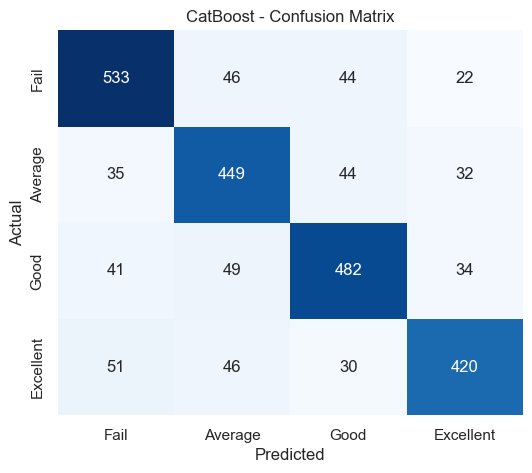

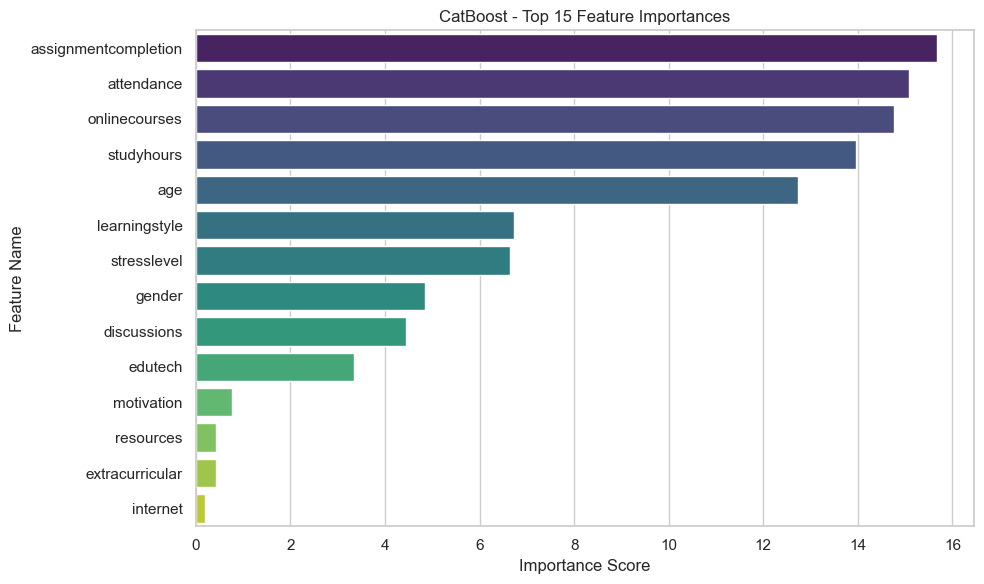

In [19]:
# CatBoost Classifier with Evaluation, Confidence Flag, and Visuals

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix
)

sns.set(style="whitegrid")

# --- Train model ---
model = CatBoostClassifier(verbose=0, random_state=42)
model.fit(X_train, y_train)

# --- Predictions and Probabilities ---
y_pred = model.predict(X_test)
probs = model.predict_proba(X_test)  # Probabilities for each class

# --- Confidence Analysis (threshold 0.5) ---
max_probs = probs.max(axis=1)
low_confidence_idx = np.where(max_probs < 0.5)[0]
print(f"\nNumber of low-confidence predictions (max_prob < 0.5): {len(low_confidence_idx)} / {len(y_test)}")

# --- Evaluation Metrics ---
print("\n=== CatBoost Classifier Performance ===")
print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=1))

# --- Confusion Matrix Visualization ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues', cbar=False,
    xticklabels=["Fail", "Average", "Good", "Excellent"],
    yticklabels=["Fail", "Average", "Good", "Excellent"]
)
plt.title("CatBoost - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --- Feature Importance ---
feature_importances = model.get_feature_importance()
feature_names = X_train.columns
feature_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# --- Feature Importance Visualization (Seaborn v0.14+ Safe) ---
plt.figure(figsize=(10, 6))
sns.barplot(
    data=feature_df.head(15),
    x='Importance',
    y='Feature',
    hue='Feature',       # Required for palette use
    palette='viridis',
    legend=False
)
plt.title("CatBoost - Top 15 Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.tight_layout()
plt.show()


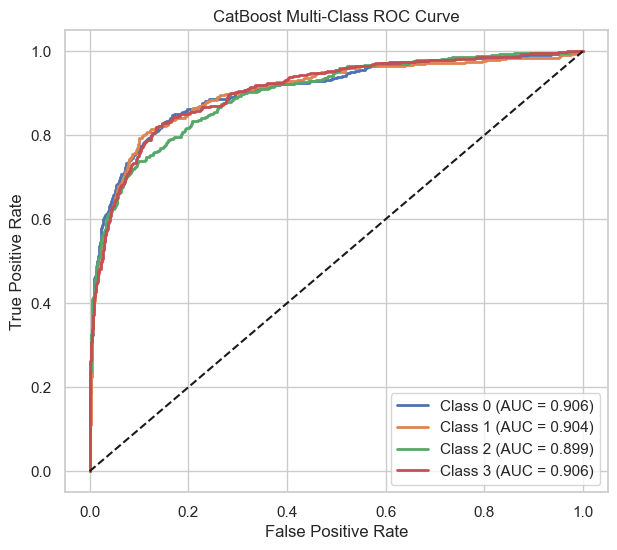

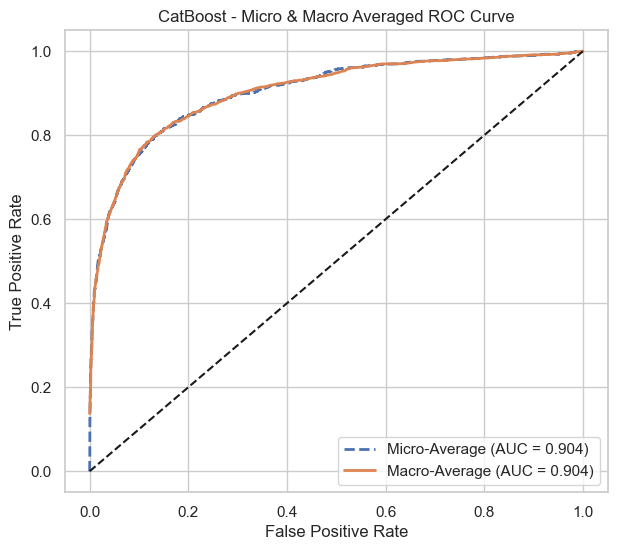


=== CatBoost AUC Score Summary ===
Class 0 AUC: 0.906
Class 1 AUC: 0.904
Class 2 AUC: 0.899
Class 3 AUC: 0.906

Micro-Averaged AUC: 0.904
Macro-Averaged AUC: 0.904



In [6]:
# Multi-Class ROC Curve + Micro/Macro AUC (CatBoost)
from catboost import CatBoostClassifier
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt

# Binarize finalgrade labels for ROC processing
classes = sorted(y.unique())        # auto-detect label classes
y_test_bin = label_binarize(y_test, classes=classes)

# Wrap CatBoost in One-vs-Rest to output properly formatted probas for ROC
cat_ovr = OneVsRestClassifier(
    CatBoostClassifier(verbose=0, random_state=42)
)
cat_ovr.fit(X_train, y_train)

# Predict probabilities
y_score = cat_ovr.predict_proba(X_test)

n_classes = y_test_bin.shape[1]

# ----------------------------
# 1. ROC Curve for Each Class
# ----------------------------
plt.figure(figsize=(7, 6))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Class {classes[i]} (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], 'k--')  # diagonal line reference
plt.title("CatBoost Multi-Class ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# ----------------------------
# 2. Micro & Macro Averaged ROC
# ----------------------------
# Micro-average AUC
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
auc_micro = auc(fpr_micro, tpr_micro)

# Macro-average AUC
auc_macro = roc_auc_score(y_test_bin, y_score, average="macro")

plt.figure(figsize=(7, 6))
plt.plot(fpr_micro, tpr_micro, linestyle="--", linewidth=2,
         label=f"Micro-Average (AUC = {auc_micro:.3f})")

# Macro curve (average of class TPR values)
mean_tpr = np.zeros_like(fpr_micro)
for i in range(n_classes):
    fpr_i, tpr_i, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    mean_tpr += np.interp(fpr_micro, fpr_i, tpr_i)
mean_tpr /= n_classes

plt.plot(fpr_micro, mean_tpr, linewidth=2,
         label=f"Macro-Average (AUC = {auc_macro:.3f})")

plt.plot([0,1], [0,1], "k--")
plt.title("CatBoost - Micro & Macro Averaged ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

# ----------------------------
# 3. AUC Summary Table (Print)
# ----------------------------
print("\n=== CatBoost AUC Score Summary ===")
for i in range(n_classes):
    class_auc = roc_auc_score(y_test_bin[:, i], y_score[:, i])
    print(f"Class {classes[i]} AUC: {class_auc:.3f}")

print(f"\nMicro-Averaged AUC: {auc_micro:.3f}")
print(f"Macro-Averaged AUC: {auc_macro:.3f}\n")
